## Setup

In [1]:
#!git clone https://github.com/pikalab-unibo-students/master-thesis-dizio-ay2324.git

In [2]:
import sys
sys.path.append('./master-thesis-dizio-ay2324')

In [3]:
import utils
import pandas as pd
import numpy as np

# Ethics
import chardet
import fairlib as fl
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

# Statistics
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

In [4]:
# Allowing reproducibility
random_seed = 42
np.random.seed(random_seed)

## Dataset Loading

In [5]:
dataset_path = 'direct_matching_20240213.csv'

In [6]:
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']


In [7]:
df = fl.DataFrame(pd.read_csv(dataset_path, delimiter=';', encoding=encoding))

## Data Preparation

We have to carefully prepare the dataset for classification avoiding <b>sample bias</b>, i.e., avoiding that the negative examples are biased. Note: we cannot do anything for an eventual bias in the hiring process (when we pick the top-1 candidate), and it would be incorrect too since our task is focusing on that kind of bias.

In [8]:
df.head(11)

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,32.327042,99.573387,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
1,"4,999,120",OFF_1011_1427,15.595593,99.210564,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
2,"5,413,671",OFF_1011_1427,31.348877,99.118614,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
3,"5,965,090",OFF_1011_1427,66.315598,97.409767,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
4,"5,771,219",OFF_1011_1427,15.595593,97.323875,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
5,"2,216,205",OFF_1011_1427,24.946939,96.922318,6,Male,55-74,UD,FRIULI VENEZIA GIULIA,Diploma / Accademia : Geometra,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
6,"4,594,051",OFF_1011_1427,27.959969,96.245216,7,Male,55-74,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
7,"5,148,878",OFF_1011_1427,25.512180,96.235245,8,Male,25-34,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
8,"5,933,345",OFF_1011_1427,28.856832,96.009712,9,Female,45-54,GO,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
9,"7,204,128",OFF_1011_1427,31.348877,95.802277,10,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD


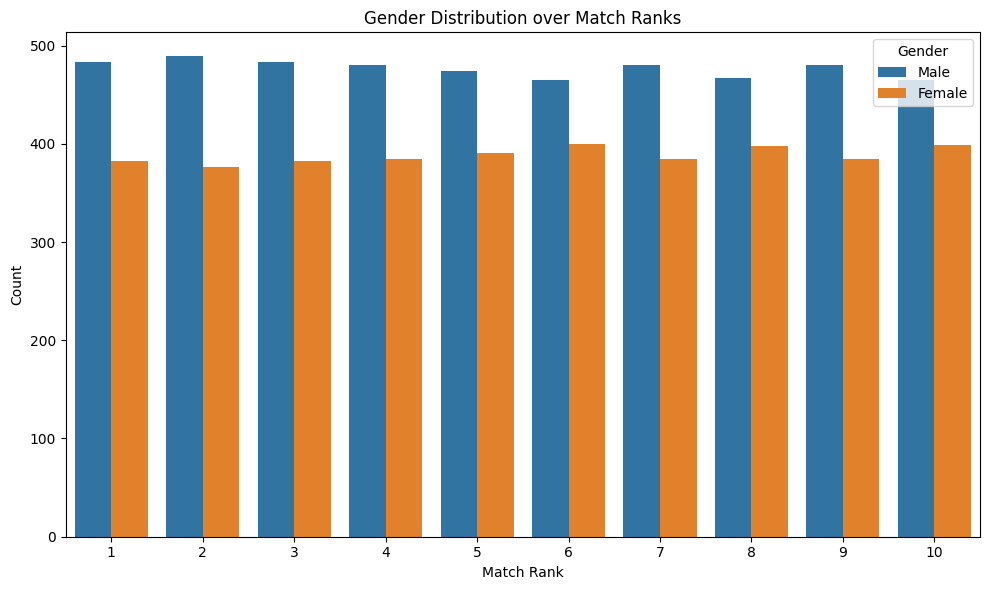

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='match_rank', hue='cand_gender', order=range(1, 11))
plt.title('Gender Distribution over Match Ranks')
plt.xlabel('Match Rank')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


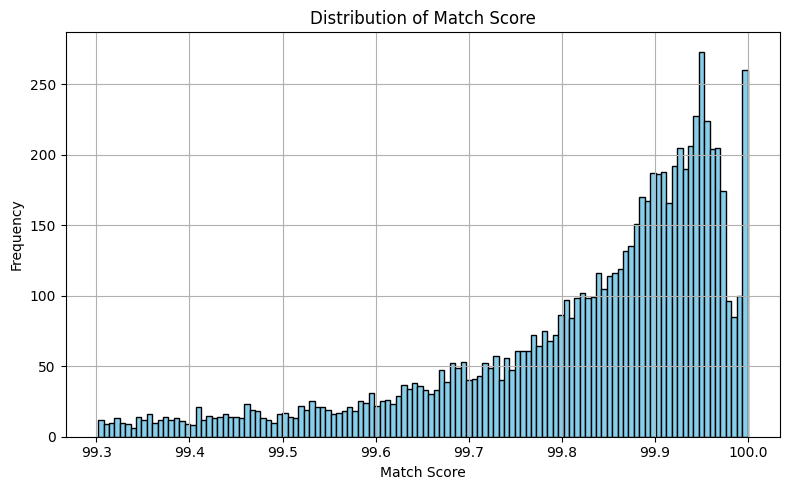

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df[df['match_score'] > 99.3]['match_score'], bins=120, color='skyblue', edgecolor='black')
plt.title('Distribution of Match Score')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

We can assume that a candidate is hired if its match score is greater than a significant threshold, for instance, th=99.8

In [11]:
hired_threshold = 99.8

In [12]:
df1 = df.copy()

In [13]:
df1['hired'] = (df1['match_score'] >= hired_threshold).astype(int)

In [14]:
df1.shape

(8647, 15)

In [15]:
len(df1[df1['hired'] == 1])

5297

In [16]:
df1.targets = {'hired'}

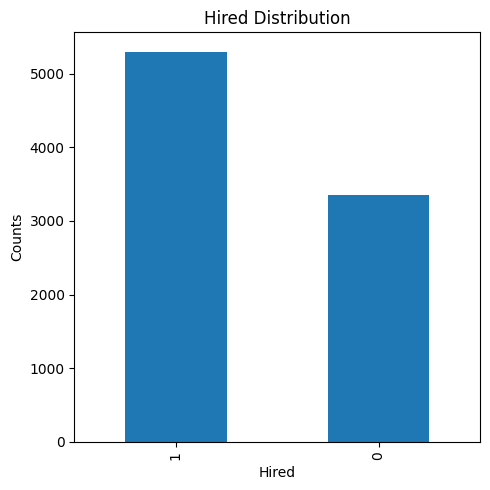

In [17]:
plt.figure(figsize=(5, 5))
df1['hired'].value_counts().plot(kind='bar')
plt.xlabel('Hired')
plt.ylabel('Counts')
plt.title('Hired Distribution')
plt.tight_layout()
plt.show()

Both the match rank and the match score are useless now that we extract the label, so we can drop them.

In [18]:
df1.drop(['match_score','match_rank'], axis=1, inplace=True)

In [19]:
df1.head()

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
0,"5,664,912",OFF_1011_1427,32.327042,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
1,"4,999,120",OFF_1011_1427,15.595593,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
2,"5,413,671",OFF_1011_1427,31.348877,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
3,"5,965,090",OFF_1011_1427,66.315598,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
4,"5,771,219",OFF_1011_1427,15.595593,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0


## Data Preprocessing

Before continuing with the data analysis we want to ensure that missing values are handled correctly and the data are ready to be feed in a classifier. Let's inspect some of their statistics.

In [20]:
print(f'Examples in the dataset: {df1.shape[0]}')

Examples in the dataset: 8647


In [21]:
df1.describe(include='all')

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,8647,8647,8647.000000,8647,8646,8644,8642,2341,8647,8647,8647,8647,8647.000000
unique,6798,865,NaN,2,5,79,18,433,3,247,26,53,NaN
top,"6,550,205",OFF_1011_1427,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Lavoro subordinato,Operaio Generico Metalmeccanico,Operai Generici,MI,NaN
freq,18,10,NaN,4766,2936,1341,3989,433,5658,770,2829,1689,NaN
mean,NaN,NaN,29.769432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.612582
std,NaN,NaN,23.493063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487189
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,12.253924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,23.447361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,41.754654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Most of the variables doen't miss any value, except for the <b>candidate domicile province</b> which misses just 3 values, the <b>candidate domicile region</b> which misses only 5 values, the <b>candidate age</b> which misses only 1 value and the <b>candidate education</b>, which instead misses way more values. We can account for the 3 missing  values by simply drop the related rows, but we must find a default value for the education since the rows containing missing values are too much.

In [22]:
df1 = df1[~df1['cand_domicile_province'].isnull()]
df1 = df1[~df1['cand_domicile_region'].isnull()]
df1 = df1[~df1['cand_age_bucket'].isnull()]

In general, we can keep all the numerical values, but we have to account for the categorical ones in order to feed a classifier. In the next paragraphs we will focus on the features that require our attention.

### IDs

Candidate id and job id are meaningless for the task of bias detection, hence we can easily drop them.

In [23]:
df1.drop(['cand_id','job_id'], axis=1, inplace=True)

### Distance Km

In [24]:
df1['distance_km'].describe()

count    8639.000000
mean       29.754485
std        23.484031
min         0.000000
25%        12.252331
50%        23.437698
75%        41.751572
max        99.966797
Name: distance_km, dtype: float64

We can approximate the distance by rounding it.

In [25]:
df1['distance_km'] = df1['distance_km'].apply(lambda d : round(d)).astype(int)

In [26]:
df1['distance_km'].describe()

count    8639.000000
mean       29.746846
std        23.475636
min         0.000000
25%        12.000000
50%        23.000000
75%        42.000000
max       100.000000
Name: distance_km, dtype: float64

First of all, let's inspect the distribution.

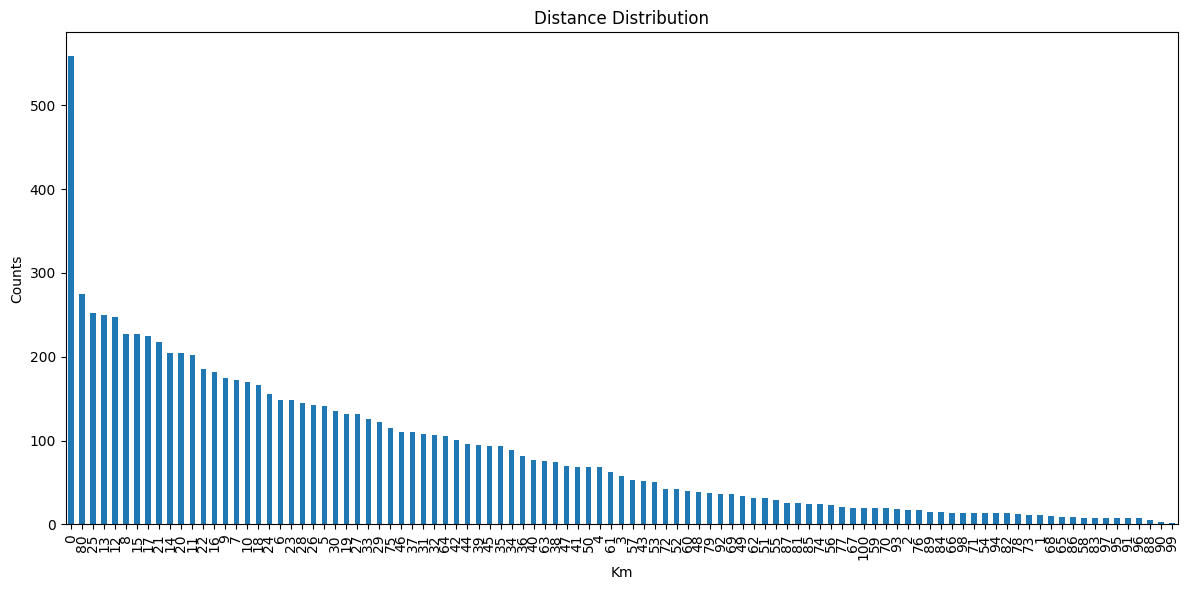

In [27]:
# Visualize the distribution
plt.figure(figsize=(12, 6))
df1['distance_km'].value_counts().plot(kind='bar')
plt.xlabel('Km')
plt.ylabel('Counts')
plt.title('Distance Distribution')
plt.tight_layout()
plt.show()

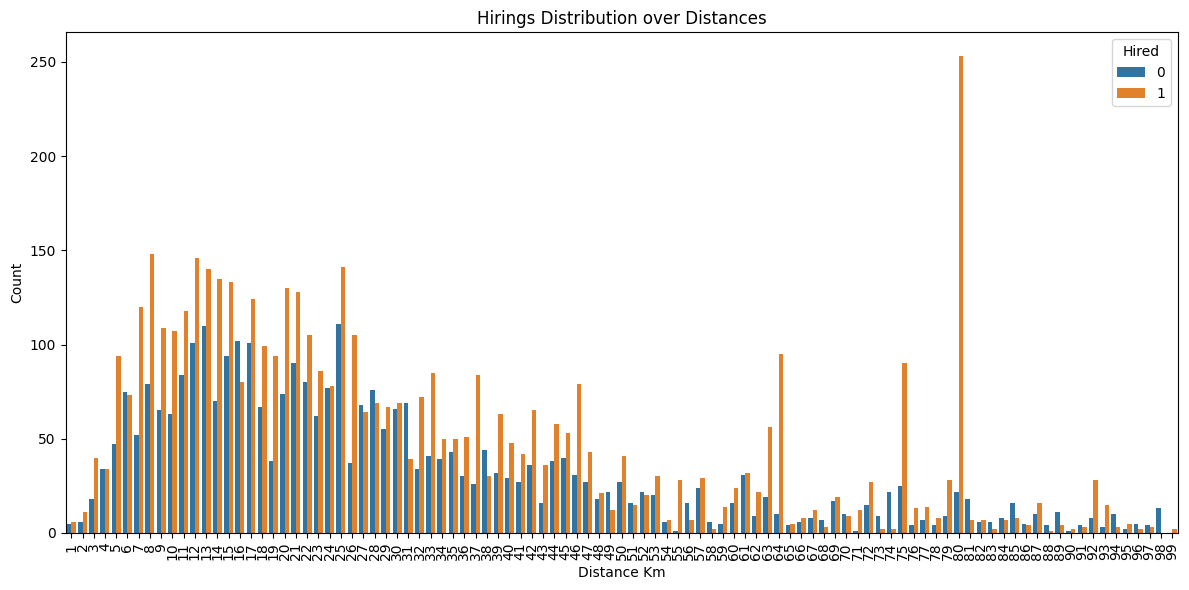

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df1, x='distance_km', hue='hired', order=range(1, max(df1['distance_km'])))
plt.title('Hirings Distribution over Distances')
plt.xlabel('Distance Km')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

There is no particular bias related to this feature. The fact that the hired counts per distance are not uniform is probably due to other factors.

### Candidate Gender

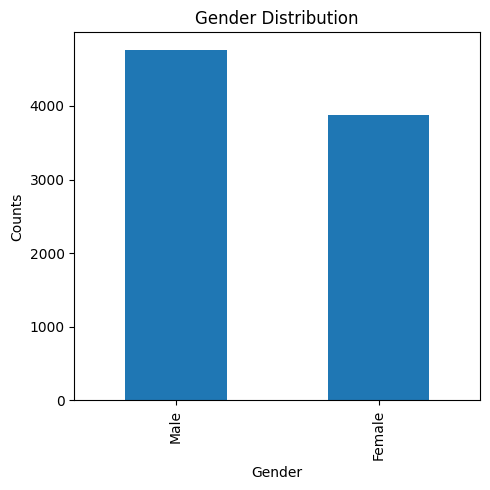

In [29]:
# Visualize the distribution
plt.figure(figsize=(5, 5))
df1['cand_gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

The dataset is imbalanced, but this tell us nothing about any possible bias or unfairness. In order to spot any kind of unfairness we should compare this distribution with the hirings.

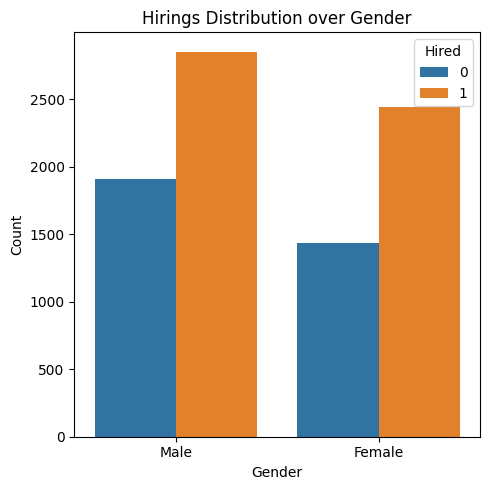

In [30]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, x='cand_gender', hue='hired')
plt.title('Hirings Distribution over Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

Here we can spot a huge gender bias, despite the distribution of genders is not uniform. We should compare this property with the other features in order to spot the various biases (in job sectors for instance).

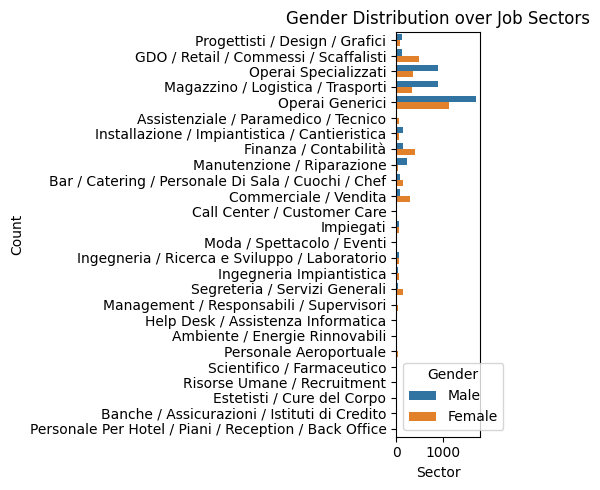

In [31]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y='job_sector', hue='cand_gender')
plt.title('Gender Distribution over Job Sectors')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

It is evident that there is some bias related to the gender in most of the sectors, so we mark it as sensitive.

In [32]:
sensitive_features = ['cand_gender']

In [33]:
# Preprocessing
#df1['cand_gender'] = df1['cand_gender'].apply(lambda s: int(str.lower(s) == 'male'))

### Candidate Province

In [34]:
df1['cand_domicile_province'].describe()

count     8639
unique      78
top         MI
freq      1340
Name: cand_domicile_province, dtype: object

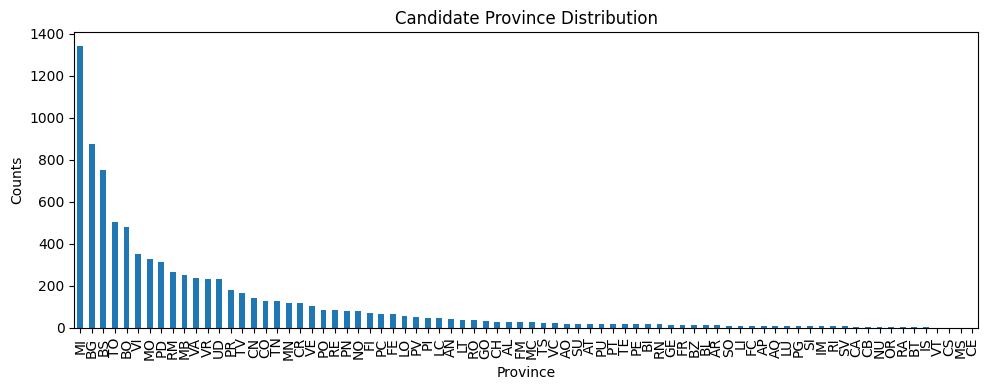

In [35]:
# Visualize the distribution
plt.figure(figsize=(10, 4))
df1['cand_domicile_province'].value_counts().plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Counts')
plt.title('Candidate Province Distribution')
plt.tight_layout()
plt.show()

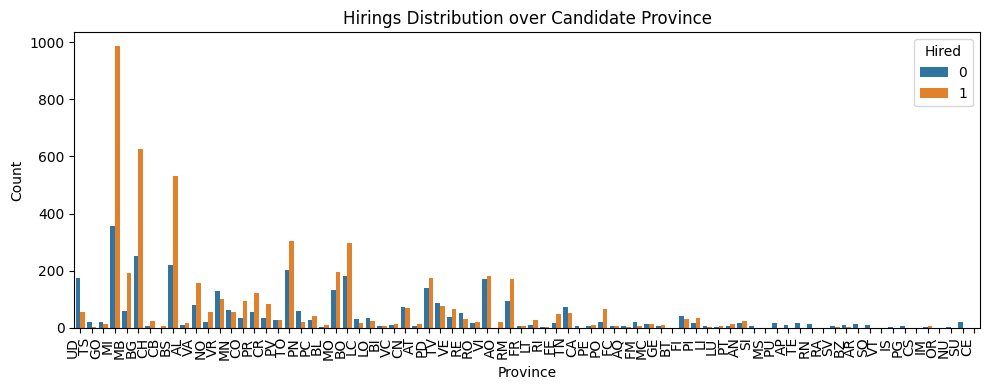

In [36]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df1, x='cand_domicile_province', hue='hired')
plt.title('Hirings Distribution over Candidate Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Here we can spot some bias towards the candidates coming from the north of Italy, but we need to aggregate the data in order to have a clearer overview.

In order to preprocess this feature, we have to ensure that even the job work province will be coherent with the candidate province, therefore we will use the same encoder for both of them.

In [37]:
province_encoder = OrdinalEncoder()
df1['cand_domicile_province'] = province_encoder.fit_transform(df1[['cand_domicile_province']])

### Domicile Region

In [38]:
df1['cand_domicile_region'].describe()

count          8639
unique           18
top       LOMBARDIA
freq           3988
Name: cand_domicile_region, dtype: object

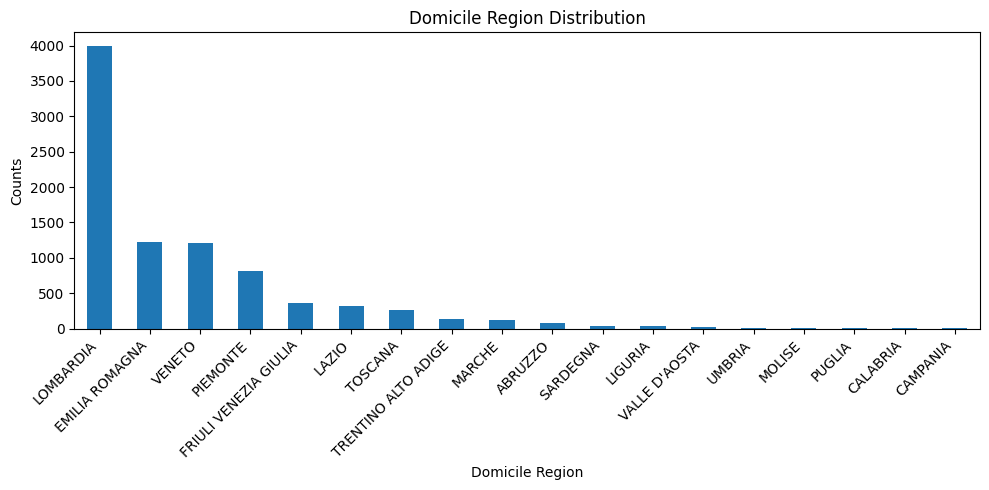

In [39]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['cand_domicile_region'].value_counts().plot(kind='bar')
plt.xlabel('Domicile Region')
plt.ylabel('Counts')
plt.title('Domicile Region Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
df_copy = df1.copy()
df_copy['gender_region'] = df_copy['cand_domicile_region'].astype(str) + ' ' + df_copy['cand_gender'].astype(str)

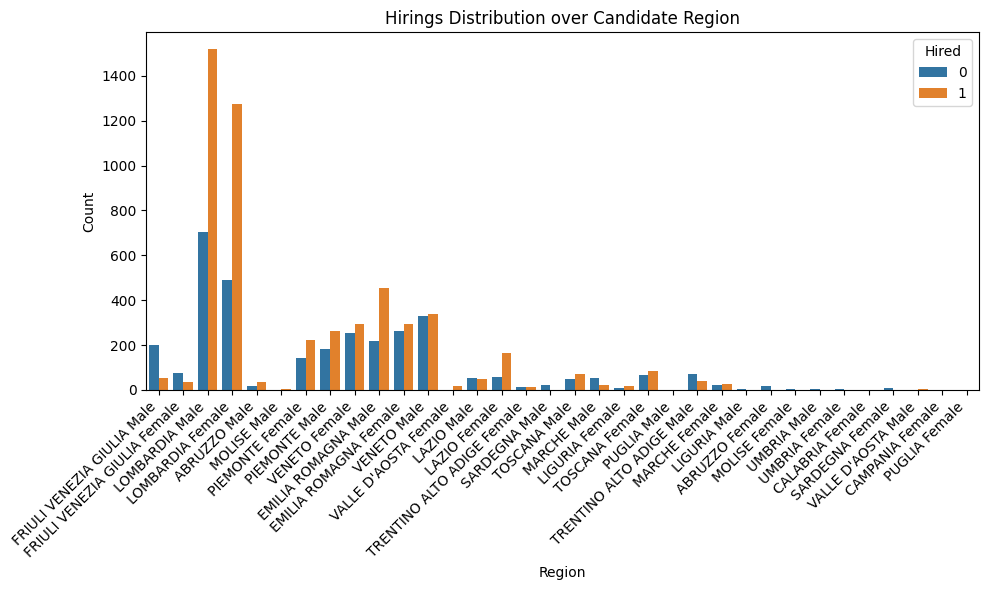

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='gender_region', hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
df_copy['gender_region'].value_counts()

gender_region
LOMBARDIA Male                  2222
LOMBARDIA Female                1766
EMILIA ROMAGNA Male              673
VENETO Male                      670
EMILIA ROMAGNA Female            557
VENETO Female                    545
PIEMONTE Male                    445
PIEMONTE Female                  366
FRIULI VENEZIA GIULIA Male       253
LAZIO Female                     222
TOSCANA Female                   149
TOSCANA Male                     118
FRIULI VENEZIA GIULIA Female     114
TRENTINO ALTO ADIGE Male         111
LAZIO Male                       100
MARCHE Male                       75
ABRUZZO Male                      54
MARCHE Female                     51
TRENTINO ALTO ADIGE Female        28
LIGURIA Female                    26
SARDEGNA Male                     22
ABRUZZO Female                    19
VALLE D'AOSTA Female              18
SARDEGNA Female                    9
MOLISE Male                        5
UMBRIA Male                        5
LIGURIA Male            

This last plot shows that there are no biases in the region, thus we can assume that there are no bias in the province feature too. Note that the regions of the south are not well represented, so any bias related to the north-south discrimination won't be catched.

A one-hot wencoding would be too heavy for too much regions, thus we can group them into south, central and north regions and then one-hot encode them.

In [43]:
region_groups = {
    # North
    'piemonte': 'north',
    'valle d\'aosta': 'north',
    'lombardia': 'north',
    'veneto': 'north',
    'friuli venezia giulia': 'north',
    'liguria': 'north',
    'emilia romagna': 'north',
    'trentino alto adige': 'north',

    # Central
    'toscana': 'central',
    'umbria': 'central',
    'marche': 'central',
    'lazio': 'central',

    # South
    'abruzzo': 'south',
    'molise': 'south',
    'campania': 'south',
    'puglia': 'south',
    'basilicata': 'south',
    'calabria': 'south',

    # Islands
    'sicilia': 'south',
    'sardegna': 'south'
}

In [44]:
grouped_regions = df1['cand_domicile_region'].apply(lambda r : region_groups[str.lower(r)])
df1['grouped_regions'] = grouped_regions.astype(str) + ' ' + df1['cand_gender'].astype(str)

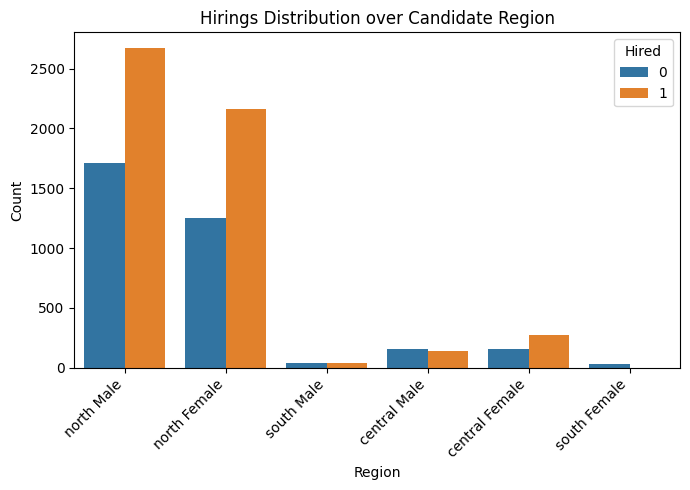

In [45]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df1, x=df1['grouped_regions'], hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [46]:
df1 = df1.drop('cand_domicile_region', axis=1)
df1 = df1.drop('cand_gender', axis=1)

In [47]:
df1.head()

,distance_km,cand_age_bucket,cand_domicile_province,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired,grouped_regions
0,32,45-54,71.0,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0,north Male
1,16,35-44,71.0,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0,north Male
2,31,45-54,71.0,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0,north Female
3,66,15-24,69.0,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0,north Male
4,16,35-44,71.0,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0,north Female


In [48]:
#grouped_regions_encoder = OrdinalEncoder()
#df1['grouped_regions'] = grouped_regions_encoder.fit_transform(df1[['grouped_regions']])

In [49]:
df1['grouped_regions'].value_counts()

grouped_regions
north Male        4380
north Female      3420
central Female     426
central Male       298
south Male          82
south Female        33
Name: count, dtype: int64

### Age Buckets

In [50]:
df1['cand_age_bucket'].unique()

array(['45-54', '35-44', '15-24', '55-74', '25-34'], dtype=object)

In [51]:
print(f"Null age buckets: {df1['cand_age_bucket'].isnull().sum()}")

Null age buckets: 0


Since it is only one we can safely drop it.

In [52]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
25-34    2935
35-44    2129
45-54    1777
55-74     956
15-24     842
Name: count, dtype: int64

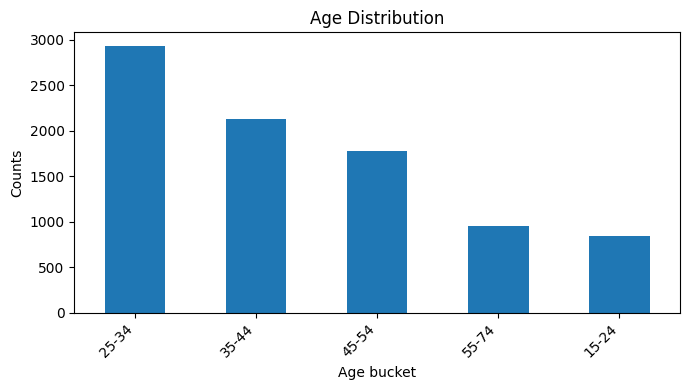

In [53]:
plt.figure(figsize=(7, 4))
df1['cand_age_bucket'].value_counts().plot(kind='bar')
plt.xlabel('Age bucket')
plt.ylabel('Counts')
plt.title('Age Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

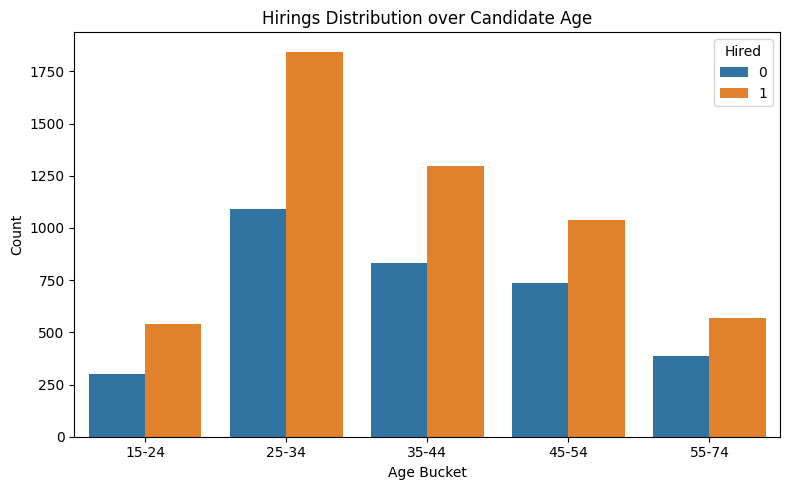

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_age_bucket', hue='hired', order=['15-24', '25-34', '35-44', '45-54', '55-74'])
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Age Bucket')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

As we can see, the bias is more heavy in the age which ranges from 25 to 34, probably because it is the mean age range where we decide to make a child, so the company wants to avoid maternity. We mark also this feature as sensitive.

In [55]:
sensitive_features.append('cand_age_bucket')

We can discretize them since they are numerical but preserves the order, thus we will use progressive enumeration.

In [56]:
age_bucket_order = {
    '15-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-74': 4,
}

df1['cand_age_bucket'] = df1['cand_age_bucket'].map(age_bucket_order).astype(int)

In [57]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
1    2935
2    2129
3    1777
4     956
0     842
Name: count, dtype: int64

### Candidate Education

In [58]:
def map_education_level(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    # Clean common formatting inconsistencies
    x = x.replace('laurea', 'degree')
    x = x.replace('diploma', 'degree')
    
    if 'dottorato' in x or 'phd' in x or 'research doctorate' in x:
        return 'PhD'
    elif 'master' in x or 'lm-' in x:
        return 'Graduate'
    elif 'bachelor' in x or 'l-' in x:
        return 'Undergraduate'
    elif 'higher technical institute' in x or 'its' in x:
        return 'Higher Technical Institute'
    elif 'qualification' in x or 'certificate' in x or 'operator' in x:
        return 'Vocational Certificate'
    elif 'high school' in x or 'liceo' in x or 'technician' in x or 'technical' in x:
        return 'High School'
    elif 'middle school' in x or 'scuola media' in x:
        return 'Middle School'
    elif 'elementary' in x:
        return 'Elementary School'
    else:
        return 'Other'


In [59]:
df1['cand_education'] = df1['cand_education'].apply(map_education_level)

In [60]:
df1['cand_education'].value_counts()

cand_education
Unknown                       6298
Other                         1546
Vocational Certificate         284
High School                    172
Higher Technical Institute     158
Graduate                       120
Undergraduate                   56
PhD                              5
Name: count, dtype: int64

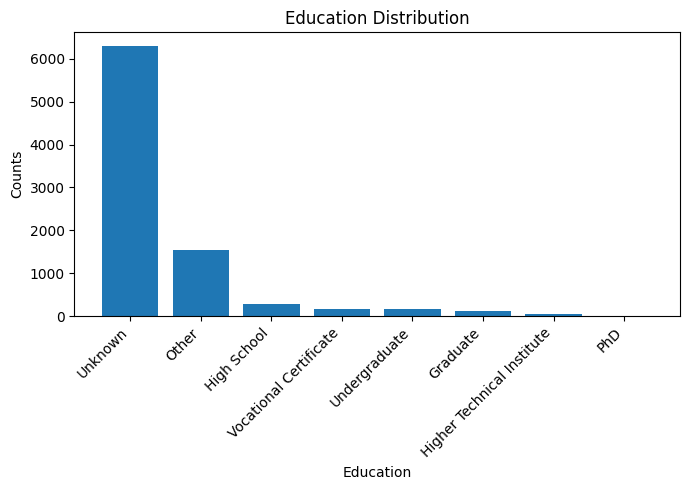

In [61]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
plt.bar(df1['cand_education'].unique(), df1['cand_education'].value_counts())
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Education Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

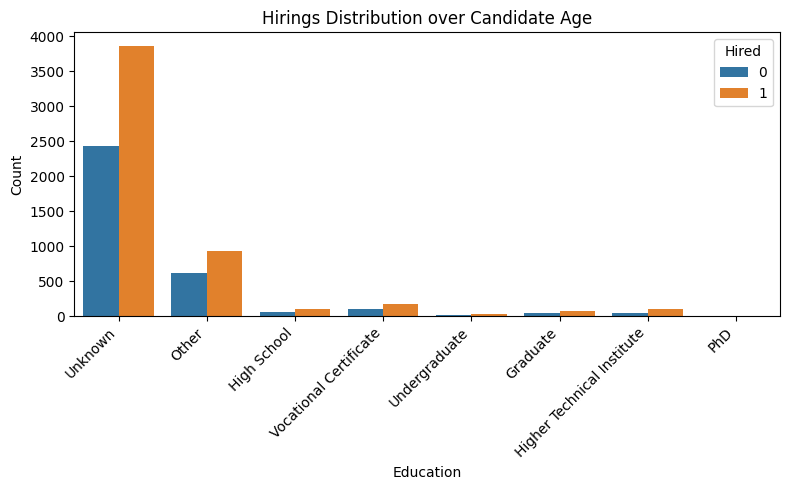

In [62]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_education', hue='hired')
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These results are probably not about any bias. However, we cannot say much looking only at this feature.

In [63]:
education_encoder = OrdinalEncoder()
df1['cand_education'] = education_encoder.fit_transform(df1[['cand_education']])

In [64]:
#df1 = pd.get_dummies(df1, columns=['cand_education'], prefix='education', drop_first=False, dtype=int)

### Job Contract Type

In [65]:
df1['job_contract_type'].describe()

count                   8639
unique                     3
top       Lavoro subordinato
freq                    5653
Name: job_contract_type, dtype: object

In [66]:
df1['job_contract_type'].value_counts()

job_contract_type
Lavoro subordinato     5653
Ricerca e selezione    2966
Other                    20
Name: count, dtype: int64

In [67]:
contract_encoder = OrdinalEncoder()
df1['job_contract_type'] = contract_encoder.fit_transform(df1[['job_contract_type']])

In [68]:
#df1 = pd.get_dummies(df1, columns=['job_contract_type'], prefix='contract', drop_first=False, dtype=int)

### Job Category

In [69]:
df1['job_professional_category'].describe()

count                                8639
unique                                247
top       Operaio Generico Metalmeccanico
freq                                  770
Name: job_professional_category, dtype: object

In [70]:
df1['job_professional_category'].unique()

array(['Geometra e tecnico di costruzioni civili e industriali',
       'Macellaio (m/f)', 'saldatore/saldatrice',
       'Capo Reparto grande distribuzione organizzata',
       'Autista di autocarro a portale (m/f)',
       'magazziniere/magazziniera', 'Operaio Generico Edile',
       'Operatore CNC (m/f)', 'Infermiere',
       'addetto alla lavorazione dei metalli',
       'O.S.S. (operatore socio sanitario)',
       'addetto controllo qualità prodotti',
       'Meccanico/Attrezzista dispositivi per la saldatura (m/f)',
       'Tecnico di cantiere', 'assistente contabile',
       "Addetto all'assemblaggio di elettrodomestici (m/f)",
       'Attrezzista di macchine per lo stampaggio (m/f)', 'Autista',
       'Operaio Generico Manifatturiero', 'Addetto al montaggio (m/f)',
       'manutentore', 'Addetto al confezionamento (m/f)',
       'Operaio Generico Servizi/Terziario',
       'Operaio Generico Gomma/Plastica', 'Addetto Fast Food',
       'Responsabile punto vendita/filiale', 'idra

In [71]:
#job_categories_group = df1['job_professional_category'].apply(lambda category : utils.map_job_category(category))

In [72]:
'''
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y=job_categories_group, hue='cand_gender')
plt.title('Gender Distribution over Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()
'''

"\nplt.figure(figsize=(5, 5))\nsns.countplot(data=df1, y=job_categories_group, hue='cand_gender')\nplt.title('Gender Distribution over Job Categories')\nplt.xlabel('Job Category')\nplt.ylabel('Count')\nplt.legend(title='Gender')\nplt.tight_layout()\nplt.show()\n"

Here it is more clear how much this dataset is biased against the gender.

In [73]:
category_encoder = OrdinalEncoder()
df1['job_professional_category'] = category_encoder.fit_transform(df1[['job_professional_category']])

In [74]:
#df1 = pd.get_dummies(df1, columns=['job_professional_category'], prefix='category', drop_first=False, dtype=int)

### Job Sector

In [75]:
df1['job_sector'].describe()

count                8639
unique                 26
top       Operai Generici
freq                 2827
Name: job_sector, dtype: object

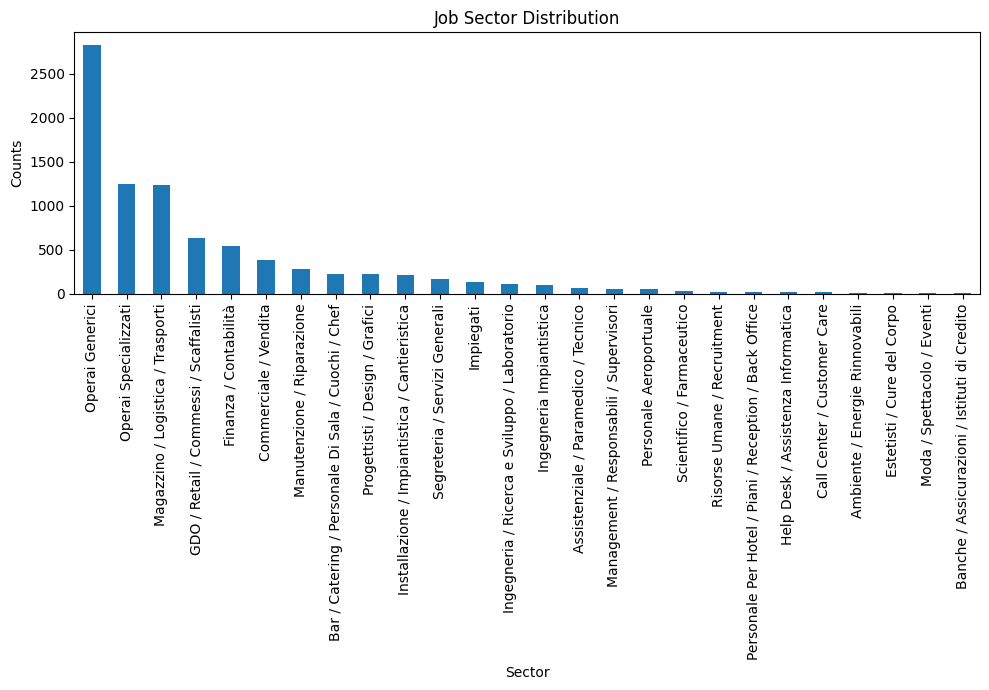

In [76]:
# Visualize the distribution
plt.figure(figsize=(10, 7))
df1['job_sector'].value_counts().plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Counts')
plt.title('Job Sector Distribution')
plt.tight_layout()
plt.show()

In [77]:
counts = df1['job_sector'].value_counts()
min_count = 30 #Statistically meaningful

rare = counts[counts < min_count].index

df1 = df1[~df1['job_sector'].isin(rare)]

In [78]:
df1['job_sector'].value_counts()

job_sector
Operai Generici                                       2827
Operai Specializzati                                  1246
Magazzino / Logistica / Trasporti                     1239
GDO / Retail / Commessi / Scaffalisti                  630
Finanza / Contabilità                                  539
Commerciale / Vendita                                  380
Manutenzione / Riparazione                             279
Bar / Catering / Personale Di Sala / Cuochi / Chef     230
Progettisti / Design / Grafici                         220
Installazione / Impiantistica / Cantieristica          210
Segreteria / Servizi Generali                          170
Impiegati                                              130
Ingegneria / Ricerca e Sviluppo / Laboratorio          110
Ingegneria Impiantistica                               100
Assistenziale / Paramedico / Tecnico                    70
Management / Responsabili / Supervisori                 60
Personale Aeroportuale                       

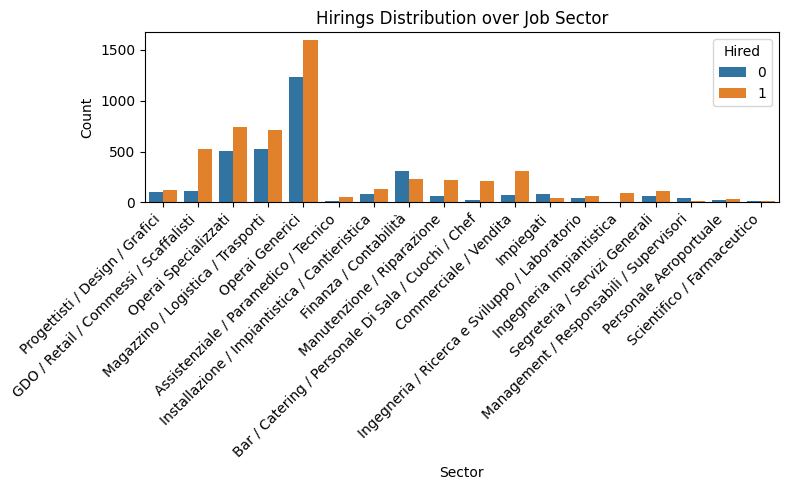

In [79]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='job_sector', hue='hired')
plt.title('Hirings Distribution over Job Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [80]:
sector_encoder = OrdinalEncoder()
df1['job_sector'] = sector_encoder.fit_transform(df1[['job_sector']])

### Job Work Province

In [81]:
df1['job_work_province'].describe()

count     8520
unique      53
top        MI 
freq      1607
Name: job_work_province, dtype: object

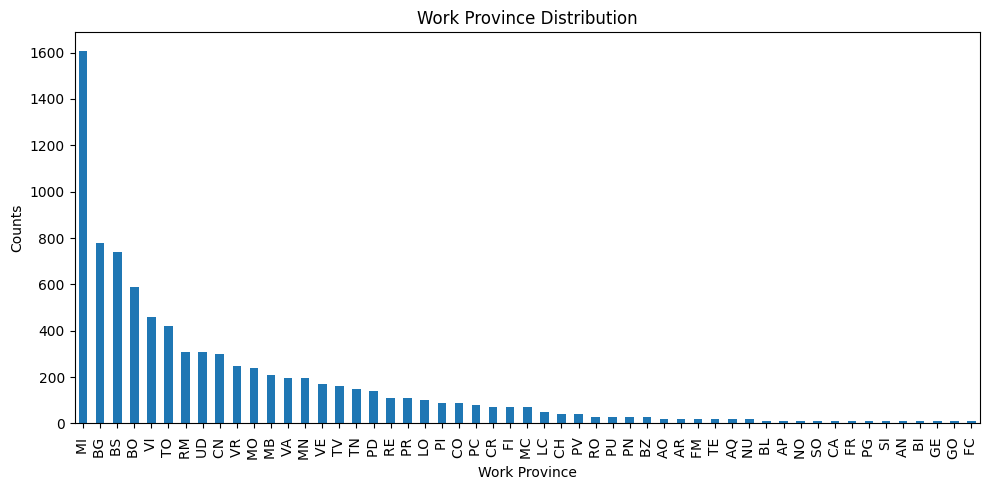

In [82]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['job_work_province'].value_counts().plot(kind='bar')
plt.xlabel('Work Province')
plt.ylabel('Counts')
plt.title('Work Province Distribution')
plt.tight_layout()
plt.show()

In [83]:
df1['job_work_province'] = province_encoder.fit_transform(df1[['job_work_province']])

In [84]:
#df1['job_work_province'] = df1['job_work_province'].apply(lambda p : province_to_idx[str.strip(p)])

### Considerations

Let's check the statistics of the dataset after the preprocessing

In [85]:
df1.describe(include='all')

,distance_km,cand_age_bucket,cand_domicile_province,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired,grouped_regions
count,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,north Male
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4350
mean,29.658803,1.892019,39.069131,5.233685,0.677465,136.788615,9.522183,27.065258,0.610681,NaN
std,23.349403,1.170752,23.577801,1.530368,0.945372,67.772409,4.105599,15.813288,0.487625,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,12.000000,1.000000,11.000000,6.000000,0.000000,91.000000,7.000000,9.000000,0.000000,NaN
50%,23.000000,2.000000,38.000000,6.000000,0.000000,126.000000,12.000000,26.000000,1.000000,NaN
75%,42.000000,3.000000,59.000000,6.000000,2.000000,203.000000,12.000000,44.000000,1.000000,NaN


As we can observe, there are no more missing values, and the target lable distribution is uniform, thus there is no unbalance.

## Correlation Matrix

In [86]:
plt.figure(figsize=(8, 8))
sns.heatmap(df1.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'north Male'

<Figure size 800x800 with 0 Axes>

There is a small negative correlation between education and gender and a stronger positive correlation between gender and job sector, but the correlation matrix is only able to catch linear correlations. As we inspected before (and as the correlation matrix suggests) the job sector seems to act as a proxy for the candidate gender, therefore we will monitor it inside the sensible features.

In [87]:
sensitive_features = ['grouped_regions']

In [88]:
df1.sensitive = set(sensitive_features)

In [89]:
df1.head()

,distance_km,cand_age_bucket,cand_domicile_province,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired,grouped_regions
0,32,3,71.0,6.0,0.0,76.0,15.0,48.0,0,north Male
1,16,2,71.0,6.0,0.0,76.0,15.0,48.0,0,north Male
2,31,3,71.0,6.0,0.0,76.0,15.0,48.0,0,north Female
3,66,0,69.0,6.0,0.0,76.0,15.0,48.0,0,north Male
4,16,2,71.0,6.0,0.0,76.0,15.0,48.0,0,north Female


## Statistical Parity Difference

In [90]:
spd = df1.statistical_parity_difference()

In [91]:
print(spd)

{(hired=0, grouped_regions=central Female): -0.032443228428667314, (hired=0, grouped_regions=central Male): 0.1391642128509833, (hired=0, grouped_regions=north Female): -0.03122806966815528, (hired=0, grouped_regions=north Male): 0.005383279583229983, (hired=0, grouped_regions=south Female): 0.5522135458508736, (hired=0, grouped_regions=south Male): 0.08712907347134619, (hired=1, grouped_regions=central Female): 0.032443228428667314, (hired=1, grouped_regions=central Male): -0.1391642128509833, (hired=1, grouped_regions=north Female): 0.03122806966815539, (hired=1, grouped_regions=north Male): -0.005383279583230038, (hired=1, grouped_regions=south Female): -0.5522135458508735, (hired=1, grouped_regions=south Male): -0.08712907347134624}


In [92]:
labels = [f"{item}" for _,item in spd[{'hired': 1}].keys()]
values = list(spd[{'hired': 1}].values())

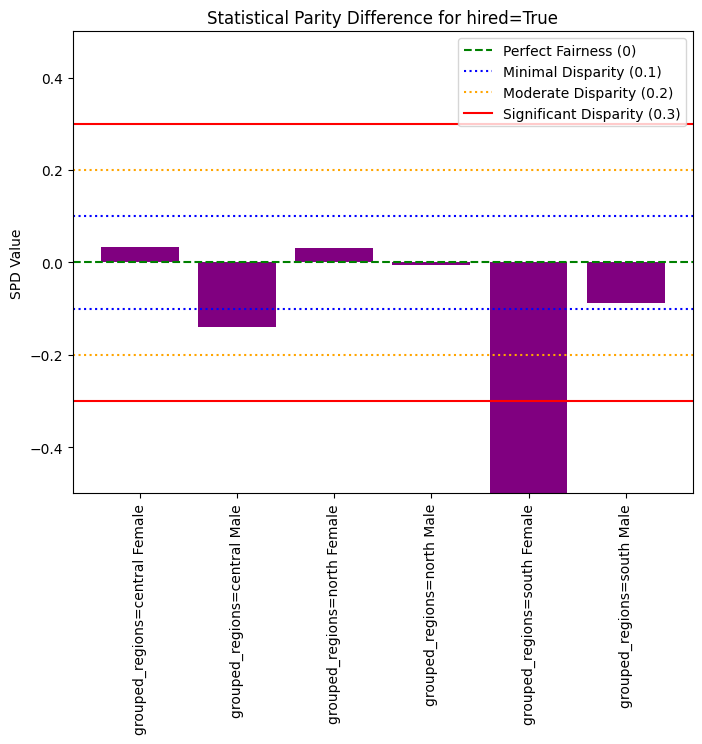

In [93]:
plt.figure(figsize=(8, 6))

plt.axhline(y=0, color='green', linestyle='--', label="Perfect Fairness (0)")

plt.axhline(y=0.1, color='blue', linestyle=':', label="Minimal Disparity (0.1)")
plt.axhline(y=-0.1, color='blue', linestyle=':')
plt.axhline(y=0.2, color='orange', linestyle=':', label="Moderate Disparity (0.2)")
plt.axhline(y=-0.2, color='orange', linestyle=':')
plt.axhline(y=0.3, color='red', linestyle='-', label="Significant Disparity (0.3)")
plt.axhline(y=-0.3, color='red', linestyle='-')

plt.bar(labels, values, color=['purple', 'purple'])


plt.title("Statistical Parity Difference for hired=True")
plt.ylabel("SPD Value")
plt.xticks(rotation=90)
plt.ylim([-0.5, 0.5])

plt.legend()
plt.show()

As we expected, we have a significant disparity for some job sectors (which is a proxy for the gender). However, since we don't have a gold standard and we set a hiring threshold arbitrarily, the results and the disparity might drastically change for some other threshold. Anyway, we will continue assuming that the true distributions of the fetures are this ones.

In [94]:
grouped_regions_encoder = OrdinalEncoder()
df1['grouped_regions'] = grouped_regions_encoder.fit_transform(df1[['grouped_regions']])

## Disparate Impact

In [ ]:
#di = df1.disparate_impact()

In [ ]:
#labels = [f"{item}" for _,item in di[{'hired': 1}].keys()]
#values = list(di[{'hired': 1}].values())

In [ ]:
'''
plt.figure(figsize=(8, 6))

# Linea di riferimento per Disparate Impact ideale
plt.axhline(y=1.0, color='green', linestyle='--', label="Perfect Fairness (1.0)")

# Soglie della regola dell'80%
plt.axhline(y=0.8, color='orange', linestyle=':', label="Acceptable Lower Bound (0.8)")
plt.axhline(y=1.25, color='orange', linestyle=':', label="Acceptable Upper Bound (1.25)")

# Linee per disparità significativa
plt.axhline(y=0.6, color='red', linestyle='-', label="Significant Disparity (<0.8 or >1.25)")
plt.axhline(y=1.5, color='red', linestyle='-')

# Barre dei modelli
plt.bar(labels, values, color='purple')

plt.title("Disparate Impact (DI) for 'Income'")
plt.ylabel("DI Value")
plt.ylim([0, 2])
plt.xticks(range(len(labels)), rotation=90)

plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(8, 6))\n\n# Linea di riferimento per Disparate Impact ideale\nplt.axhline(y=1.0, color=\'green\', linestyle=\'--\', label="Perfect Fairness (1.0)")\n\n# Soglie della regola dell\'80%\nplt.axhline(y=0.8, color=\'orange\', linestyle=\':\', label="Acceptable Lower Bound (0.8)")\nplt.axhline(y=1.25, color=\'orange\', linestyle=\':\', label="Acceptable Upper Bound (1.25)")\n\n# Linee per disparità significativa\nplt.axhline(y=0.6, color=\'red\', linestyle=\'-\', label="Significant Disparity (<0.8 or >1.25)")\nplt.axhline(y=1.5, color=\'red\', linestyle=\'-\')\n\n# Barre dei modelli\nplt.bar(labels, values, color=\'purple\')\n\nplt.title("Disparate Impact (DI) for \'Income\'")\nplt.ylabel("DI Value")\nplt.ylim([0, 2])\nplt.xticks(range(len(labels)), rotation=90)\n\nplt.legend()\nplt.show()\n'

# Classification

In [ ]:
# aggiungere cross-validation

In [95]:
sensitive_feature = 'grouped_regions'
target = df1.targets.pop()

In [96]:
def compute_performance_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_proba)
    }

In [97]:
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    return {
        'dpr': demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features),
        'eor': equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    }

In [98]:
def evaluate_spd(X_test, y_pred):
    X_test_copy = X_test.copy()
    X_test_copy[target] = y_pred
    dataset = fl.DataFrame(X_test_copy)
    dataset.targets = target
    dataset.sensitive = sensitive_feature

    spd = dataset.statistical_parity_difference()
    return spd

In [99]:
def metrics_bar_plot(dict1, dict2, label1, label2, metrics, title="Metric Comparison (mean ± std)"):
    import numpy as np
    import matplotlib.pyplot as plt

    def summarise(fold_dicts):
        means = []
        stds = []
        for m in metrics:
            values = [fold.get(m, np.nan) for fold in fold_dicts]
            # Usa nanmean e nanstd per evitare problemi con NaN
            mean_val = np.nanmean(values)
            std_val = np.nanstd(values)
            means.append(mean_val)
            stds.append(std_val)
        return np.array(means), np.array(stds)

    mean1, std1 = summarise(dict1)
    mean2, std2 = summarise(dict2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for ax, mean, std, label in zip(axes, [mean1, mean2], [std1, std2], [label1, label2]):
        ax.bar(metrics, mean, yerr=std, capsize=4)
        ax.set_title(label)
        ax.set_ylim(0, 1.2)  # leggermente sopra 1 per sicurezza
        ax.grid(axis="y", alpha=0.3)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [100]:
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        input_dim = df1.shape[-1]-1
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

## 1) Adversarial Debiasing

In [101]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

In [102]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km', 'cand_domicile_province', 'cand_education', 'job_professional_category', 'job_sector', 'job_work_province']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


#### Baseline

In [103]:
from fairlib.inprocessing import AdversarialDebiasing

X_train_dataframe = fl.DataFrame(X_train.copy())
X_train_dataframe.sensitive = sensitive_feature

baseline_model = AdversarialDebiasing(
    input_dim=X_train.shape[1],
    hidden_dim=8,
    output_dim=1,
    sensitive_dim=1,
    lambda_adv=0,  
)

baseline_model.fit(X_train, y_train)

X_test_dataframe = fl.DataFrame(X_test.copy())
X_test_dataframe.sensitive = sensitive_feature

y_pred_tensor = baseline_model.predict(X_test)
y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
y_pred_labels = (y_pred > 0.5).astype(int)

y_proba = y_pred  
perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
baseline_performance_metrics.append(perf_metrics)

# Fairness metrics
fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
baseline_fairness_metrics.append(fair_metrics)

# SPD aggiuntivo (usando metodo fairlib)
spd = evaluate_spd(X_test.copy(), y_pred_labels)
baseline_spd_val = sum(abs(v) for v in spd.values()) / len(spd)
print(f"Baseline SPD (AdversarialDebiasing λ=0): {spd}")

Baseline SPD (AdversarialDebiasing λ=0): {(hired=0, grouped_regions=0.0): -0.08322074338114813, (hired=0, grouped_regions=1.0): 0.05459937858958669, (hired=0, grouped_regions=2.0): -0.054203127909141696, (hired=0, grouped_regions=3.0): 0.06010360660884581, (hired=0, grouped_regions=4.0): -0.0603598049655327, (hired=0, grouped_regions=5.0): 0.02443136973523713, (hired=1, grouped_regions=0.0): 0.08322074338114815, (hired=1, grouped_regions=1.0): -0.054599378589586633, (hired=1, grouped_regions=2.0): 0.054203127909141724, (hired=1, grouped_regions=3.0): -0.06010360660884584, (hired=1, grouped_regions=4.0): 0.060359804965532615, (hired=1, grouped_regions=5.0): -0.024431369735237185}


#### With different adversary weights

In [104]:
# In-processing con Adversarial Debiasing su diversi lambda_adv
adv_weights = [0.1, 0.5, 1.0]
adv_spds = []
for lam in adv_weights:
    print(f"\n== Adversarial Debiasing con lambda_adv={lam} ==")

    # Prepara fairlib dataframe
    X_tr = fl.DataFrame(X_train.copy())
    X_tr.sensitive = sensitive_feature

    X_te = fl.DataFrame(X_test.copy())
    X_te.sensitive = sensitive_feature

    # Modello Adversarial Debiasing
    model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=lam,
    )

    # Addestramento
    model.fit(X_train, y_train)

    # Predizione
    y_pred_tensor = model.predict(X_test)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    y_proba = y_pred

    # Performance
    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
    inprocessing_performance_metrics.append(perf_metrics)

    # Fairness
    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
    inprocessing_fairness_metrics.append(fair_metrics)

    # SPD extra
    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)
    adv_spds.append(spd_val)
    print(f"SPD (λ={lam}): {spd}")


== Adversarial Debiasing con lambda_adv=0.1 ==
SPD (λ=0.1): {(hired=0, grouped_regions=0.0): 0.06444936326788742, (hired=0, grouped_regions=1.0): 0.08739290085679316, (hired=0, grouped_regions=2.0): -0.0026764103518897853, (hired=0, grouped_regions=3.0): -0.01499646795651663, (hired=0, grouped_regions=4.0): -0.17183209101608474, (hired=0, grouped_regions=5.0): -0.12700007175145295, (hired=1, grouped_regions=0.0): -0.06444936326788742, (hired=1, grouped_regions=1.0): -0.08739290085679319, (hired=1, grouped_regions=2.0): 0.002676410351889813, (hired=1, grouped_regions=3.0): 0.014996467956516546, (hired=1, grouped_regions=4.0): 0.17183209101608476, (hired=1, grouped_regions=5.0): 0.127000071751453}

== Adversarial Debiasing con lambda_adv=0.5 ==
SPD (λ=0.5): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

== Advers

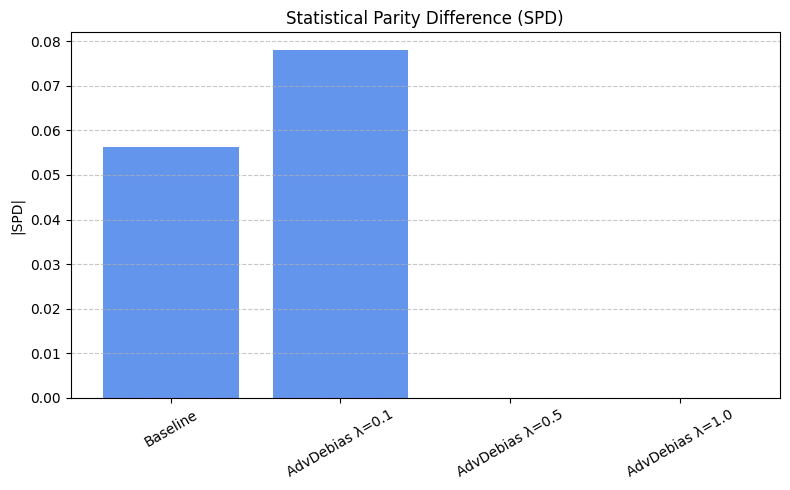

In [105]:
model_names = ['Baseline'] + [f'AdvDebias λ={lam}' for lam in adv_weights]
spds = [baseline_spd_val] + adv_spds

results = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

# Plot a barre
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['SPD'], color='cornflowerblue')
plt.title('Statistical Parity Difference (SPD)')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


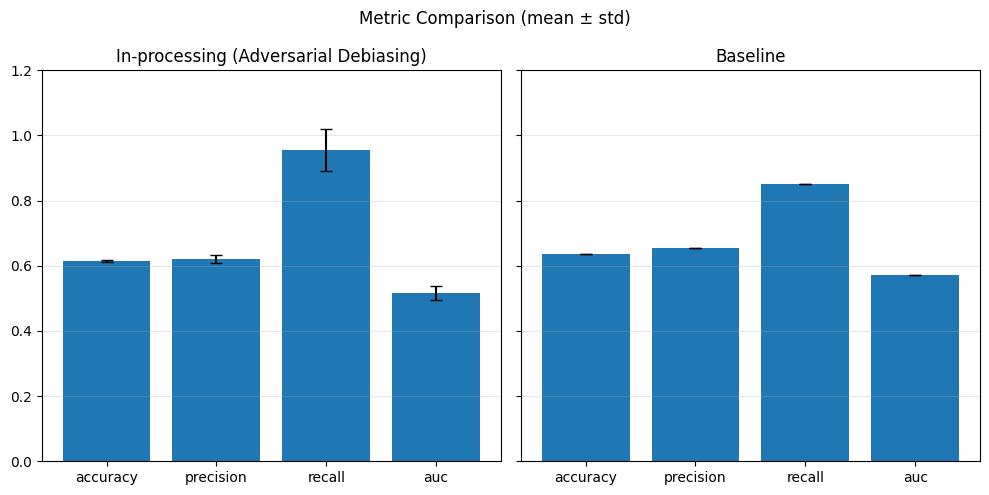

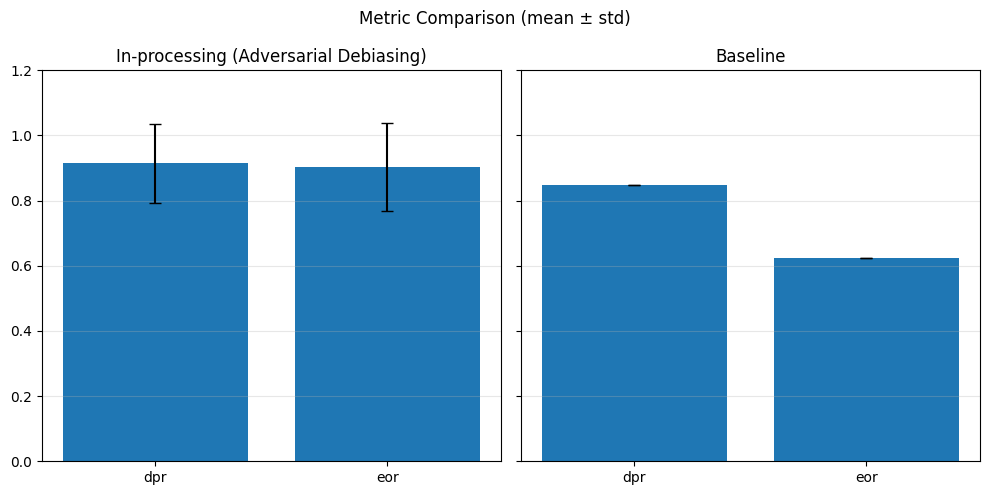

In [106]:
metrics_bar_plot(
    inprocessing_performance_metrics, 
    baseline_performance_metrics, 
    "In-processing (Adversarial Debiasing)", 
    "Baseline", 
    ["accuracy", "precision", "recall", "auc"]
)

metrics_bar_plot(
    inprocessing_fairness_metrics, 
    baseline_fairness_metrics, 
    "In-processing (Adversarial Debiasing)", 
    "Baseline", 
    ["dpr", "eor"]
)

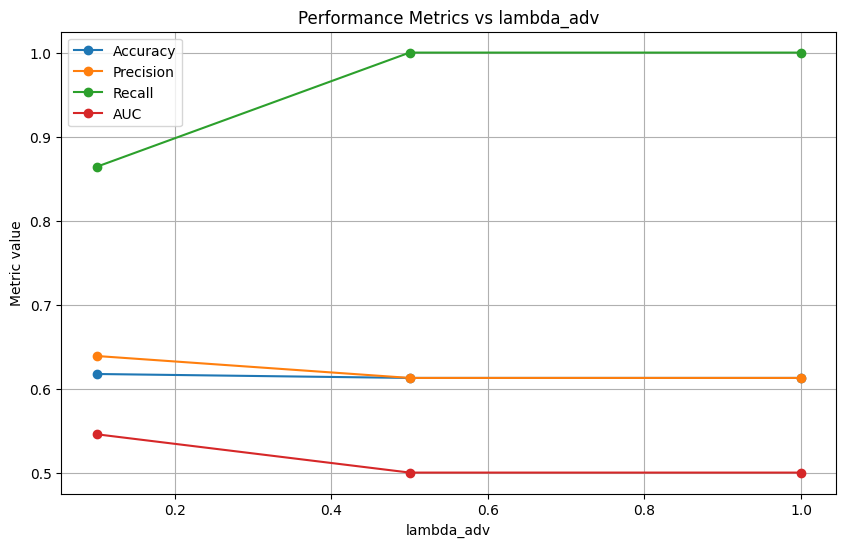

In [107]:
lambda_vals = [0.1, 0.5, 1.0]
accuracies = [m['accuracy'] for m in inprocessing_performance_metrics]
precisions = [m['precision'] for m in inprocessing_performance_metrics]
recalls = [m['recall'] for m in inprocessing_performance_metrics]
aucs = [m['auc'] for m in inprocessing_performance_metrics]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, accuracies, marker='o', label='Accuracy')
plt.plot(lambda_vals, precisions, marker='o', label='Precision')
plt.plot(lambda_vals, recalls, marker='o', label='Recall')
plt.plot(lambda_vals, aucs, marker='o', label='AUC')
plt.xlabel('lambda_adv')
plt.ylabel('Metric value')
plt.title('Performance Metrics vs lambda_adv')
plt.legend()
plt.grid(True)
plt.show()


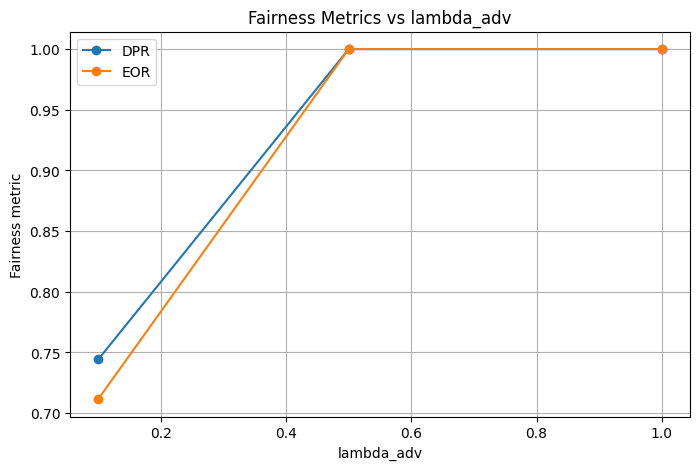

In [108]:
dprs = [m['dpr'] for m in inprocessing_fairness_metrics]
eors = [m['eor'] for m in inprocessing_fairness_metrics]

plt.figure(figsize=(8, 5))
plt.plot(lambda_vals, dprs, marker='o', label='DPR')
plt.plot(lambda_vals, eors, marker='o', label='EOR')
plt.xlabel('lambda_adv')
plt.ylabel('Fairness metric')
plt.title('Fairness Metrics vs lambda_adv')
plt.legend()
plt.grid(True)
plt.show()


## 2) FaUCI

In [109]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

In [110]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km', 'cand_domicile_province', 'cand_education', 'job_professional_category', 'job_sector', 'job_work_province']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

sensitive_idx = X_train.columns.get_loc(sensitive_feature)
sensitive_train = X_train.iloc[:, sensitive_idx].values
sensitive_test = X_test.iloc[:, sensitive_idx].values

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [111]:
fauci_spd_vals = []  

reg_weights = [0.0, 0.01, 0.1, 0.3, 0.5, 0.6]

epochs = 100
batch_size = 128

for weight in reg_weights:
    print(f"\n== FaUCI training with regularization weight: {weight} ==")

    model = Simple_NN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    fauci_model = fl.Fauci(
        torchModel=model,
        optimizer=optimizer,
        loss=nn.BCELoss(),
        fairness_regularization="spd",
        regularization_weight=weight
    )

    # Prepara dati
    train_data = fl.DataFrame(X_train_scaled)
    train_data[target] = y_train.values
    train_data.targets = target
    train_data.sensitive = sensitive_feature

    fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

    # Valutazione
    model.eval()
    with torch.no_grad():
        y_pred_tensor = fauci_model.predict(X_test_tensor)
        y_pred = y_pred_tensor.cpu().numpy().flatten()
        y_pred_labels = (y_pred > 0.5).astype(int)

    # Performance
    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_pred)

    # Fairness
    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])

    # SPD
    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    if weight == 0.0:
        baseline_performance_metrics.append(perf_metrics)
        baseline_fairness_metrics.append(fair_metrics)
        baseline_spd_val = spd_val
        print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
    else:
        inprocessing_performance_metrics.append(perf_metrics)
        inprocessing_fairness_metrics.append(fair_metrics)
        fauci_spd_vals.append(spd_val)
        print(f"[λ={weight}] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")


== FaUCI training with regularization weight: 0.0 ==
[Baseline] Accuracy: 0.6905, SPD: 0.0559

== FaUCI training with regularization weight: 0.01 ==
[λ=0.01] Accuracy: 0.6698, SPD: 0.0756

== FaUCI training with regularization weight: 0.1 ==
[λ=0.1] Accuracy: 0.6541, SPD: 0.0926

== FaUCI training with regularization weight: 0.3 ==
[λ=0.3] Accuracy: 0.5845, SPD: 0.1014

== FaUCI training with regularization weight: 0.5 ==
[λ=0.5] Accuracy: 0.3901, SPD: 0.0121

== FaUCI training with regularization weight: 0.6 ==
[λ=0.6] Accuracy: 0.3873, SPD: 0.0000


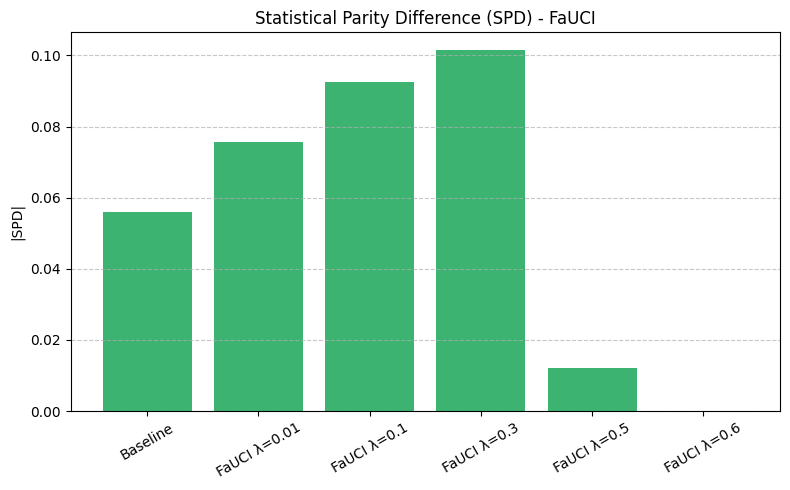

In [112]:
# Crea i nomi dei modelli
model_names = ['Baseline'] + [f'FaUCI λ={w}' for w in reg_weights if w != 0.0]
spds = [baseline_spd_val] + fauci_spd_vals

results = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['SPD'], color='mediumseagreen')
plt.title('Statistical Parity Difference (SPD) - FaUCI')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


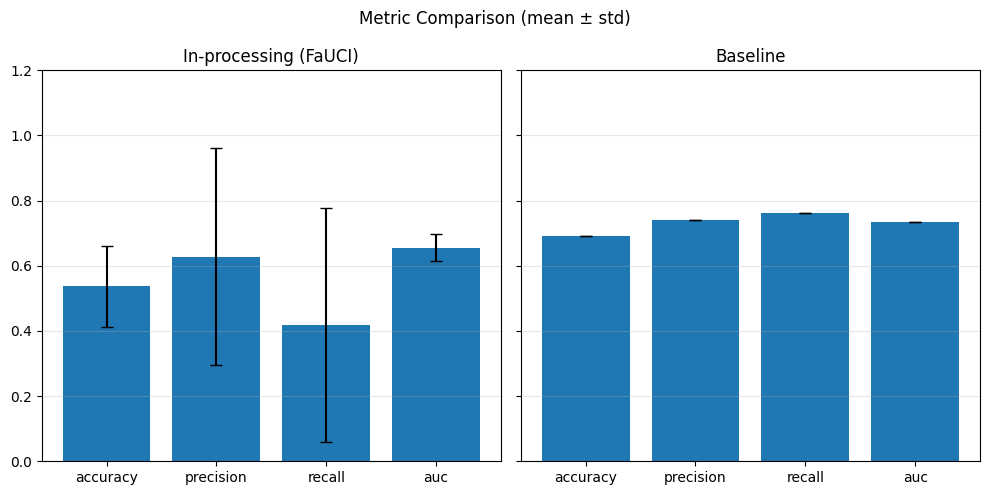

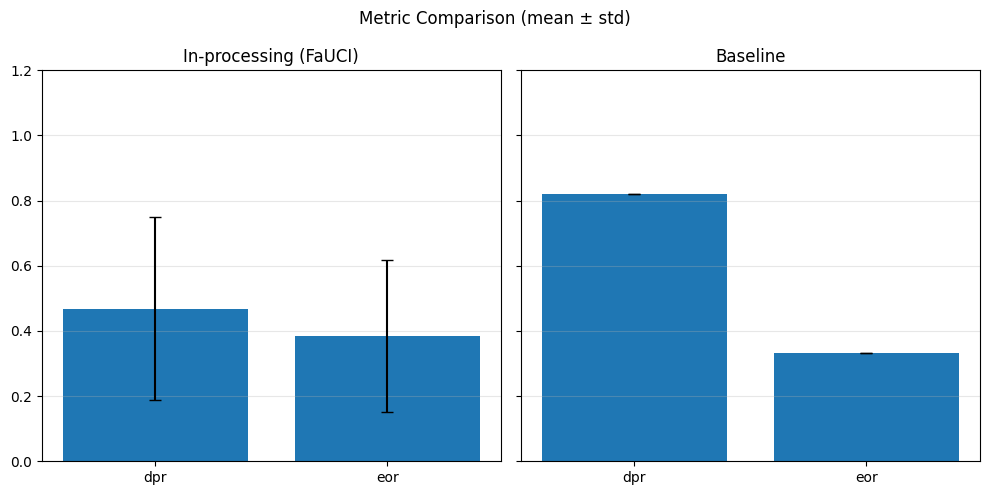

In [113]:
metrics_bar_plot(
    inprocessing_performance_metrics, 
    baseline_performance_metrics, 
    "In-processing (FaUCI)", 
    "Baseline", 
    ["accuracy", "precision", "recall", "auc"]
)

metrics_bar_plot(
    inprocessing_fairness_metrics, 
    baseline_fairness_metrics, 
    "In-processing (FaUCI)", 
    "Baseline", 
    ["dpr", "eor"]
)


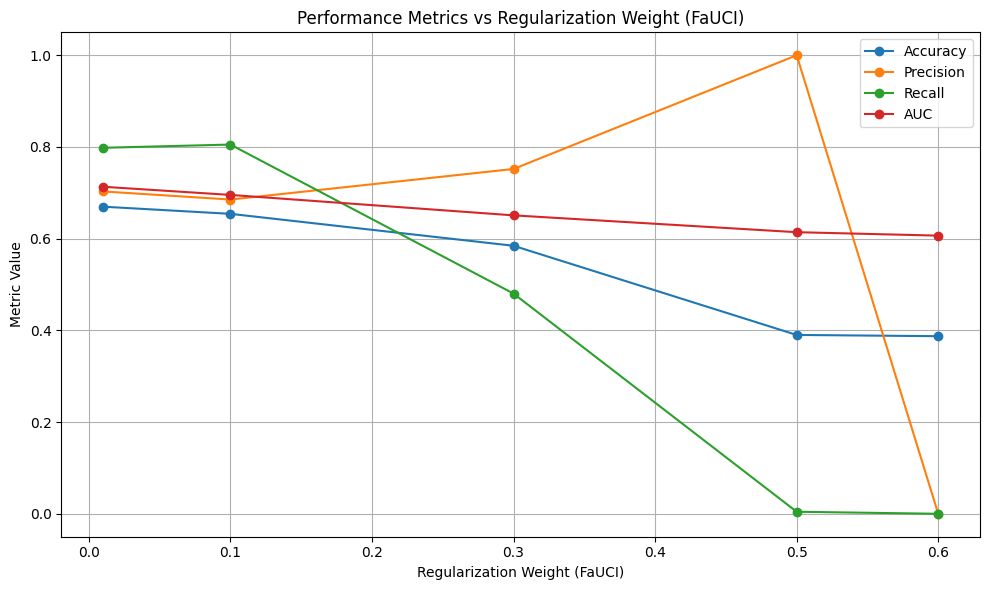

In [114]:
accuracies = [m['accuracy'] for m in inprocessing_performance_metrics]
precisions = [m['precision'] for m in inprocessing_performance_metrics]
recalls = [m['recall'] for m in inprocessing_performance_metrics]
aucs = [m['auc'] for m in inprocessing_performance_metrics]

reg_weights = [w for w in reg_weights if w != 0.0]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(reg_weights, accuracies, marker='o', label='Accuracy')
plt.plot(reg_weights, precisions, marker='o', label='Precision')
plt.plot(reg_weights, recalls, marker='o', label='Recall')
plt.plot(reg_weights, aucs, marker='o', label='AUC')
plt.xlabel('Regularization Weight (FaUCI)')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Regularization Weight (FaUCI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


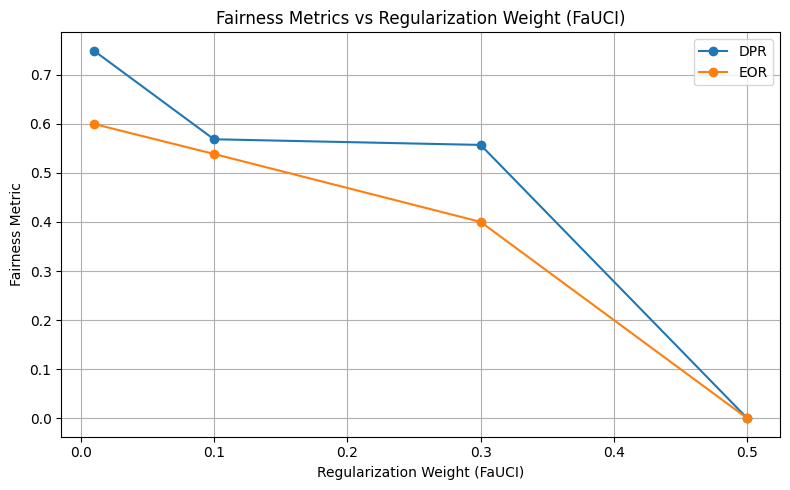

In [115]:
# Estrai le fairness metrics dai modelli FaUCI
dprs = [m['dpr'] for m in inprocessing_fairness_metrics]
eors = [m['eor'] for m in inprocessing_fairness_metrics]

reg_weights = [w for w in reg_weights if w != 0.0]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(reg_weights, dprs, marker='o', label='DPR')
plt.plot(reg_weights, eors, marker='o', label='EOR')
plt.xlabel('Regularization Weight (FaUCI)')
plt.ylabel('Fairness Metric')
plt.title('Fairness Metrics vs Regularization Weight (FaUCI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3) Prejudice Remover

In [116]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

In [117]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

train_df = fl.DataFrame(pd.concat([X_train, y_train], axis=1))
train_df.targets = target
train_df.sensitive = sensitive_feature

test_df = fl.DataFrame(pd.concat([X_test, y_test], axis=1))
test_df.targets = target
test_df.sensitive = sensitive_feature

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [118]:
pr_spd_vals = []

etas = [0.0, 0.01, 0.1, 0.3, 0.5, 0.6]

epochs = 100
batch_size = 128

for eta in etas:
    print(f"\n== PrejudiceRemover training with eta: {eta} ==")

    model = Simple_NN()
    pr_model = fl.PrejudiceRemover(model, loss=nn.BCELoss(), eta=eta)

    # Prepara dati
    train_data = fl.DataFrame(X_train_scaled)
    train_data[target] = y_train.values
    train_data.targets = target
    train_data.sensitive = sensitive_feature

    test_data = fl.DataFrame(X_test_scaled)
    test_data[target] = y_test.values
    test_data.targets = target
    test_data.sensitive = sensitive_feature

    pr_model.fit(train_data, epochs=epochs, batch_size=batch_size)

    # Valutazione
    target_col = list(test_data.targets)[0]
    sensitive_col = list(test_data.sensitive)[0]
    X_test_df = test_data.drop(columns=target_col)
    y_true = test_data[target_col].to_numpy()

    y_pred_tensor = pr_model.predict(X_test_df)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Performance
    perf_metrics = compute_performance_metrics(y_true, y_pred_bin, y_pred)

    # Fairness
    fair_metrics = compute_fairness_metrics(y_true, y_pred_bin, X_test_df[sensitive_col])

    # SPD
    spd = evaluate_spd(X_test_df.copy(), y_pred_bin)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    if eta == 0.0:
        baseline_performance_metrics.append(perf_metrics)
        baseline_fairness_metrics.append(fair_metrics)
        baseline_spd_val = spd_val
        print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
    else:
        inprocessing_performance_metrics.append(perf_metrics)
        inprocessing_fairness_metrics.append(fair_metrics)
        pr_spd_vals.append(spd_val)
        print(f"[η={eta}] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")



== PrejudiceRemover training with eta: 0.0 ==
[Baseline] Accuracy: 0.6858, SPD: 0.0926

== PrejudiceRemover training with eta: 0.01 ==
[η=0.01] Accuracy: 0.6831, SPD: 0.0608

== PrejudiceRemover training with eta: 0.1 ==
[η=0.1] Accuracy: 0.6972, SPD: 0.1128

== PrejudiceRemover training with eta: 0.3 ==
[η=0.3] Accuracy: 0.6862, SPD: 0.0658

== PrejudiceRemover training with eta: 0.5 ==
[η=0.5] Accuracy: 0.6721, SPD: 0.0320

== PrejudiceRemover training with eta: 0.6 ==
[η=0.6] Accuracy: 0.6792, SPD: 0.0839


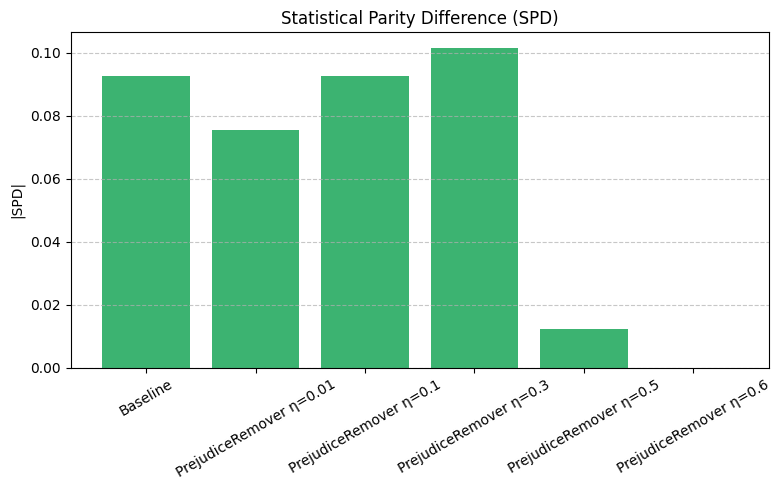

In [119]:
model_names = ['Baseline'] + [f'PrejudiceRemover η={w}' for w in reg_weights]

spds = [baseline_spd_val] + fauci_spd_vals

results_df = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

# 5. Plot SPD
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['SPD'], color='mediumseagreen')
plt.title('Statistical Parity Difference (SPD)')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


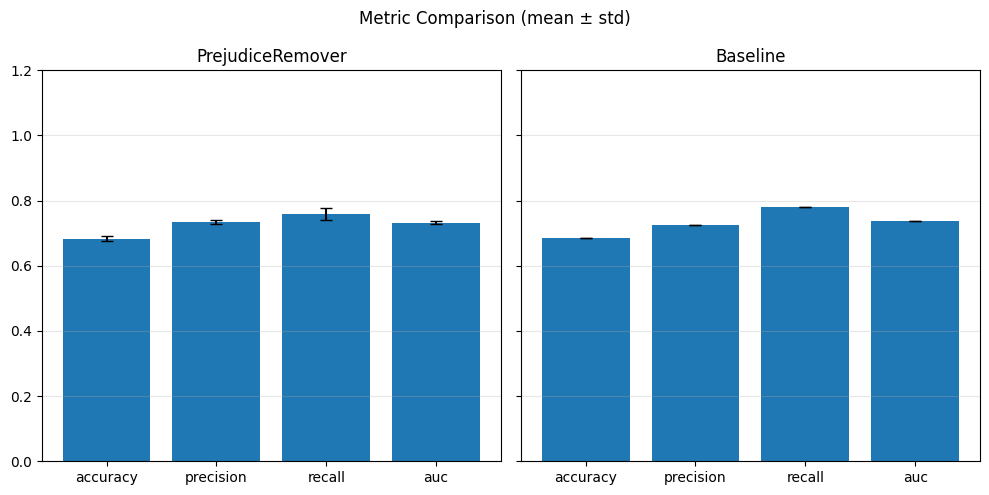

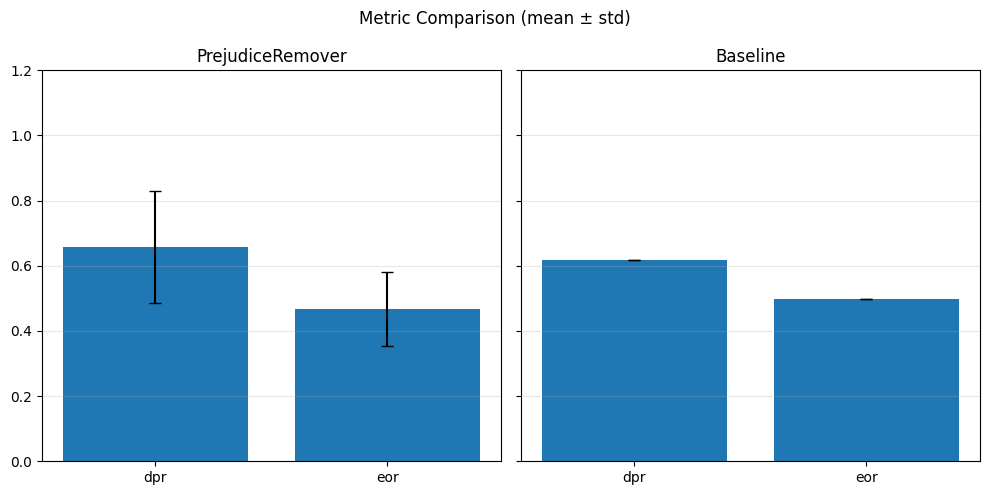

In [120]:
metrics_bar_plot(
    inprocessing_performance_metrics, 
    baseline_performance_metrics,  
    "PrejudiceRemover", 
    "Baseline", 
    ["accuracy", "precision", "recall", "auc"]
)

metrics_bar_plot(
    inprocessing_fairness_metrics, 
    baseline_fairness_metrics,
    "PrejudiceRemover", 
    "Baseline", 
    ["dpr", "eor"]
)


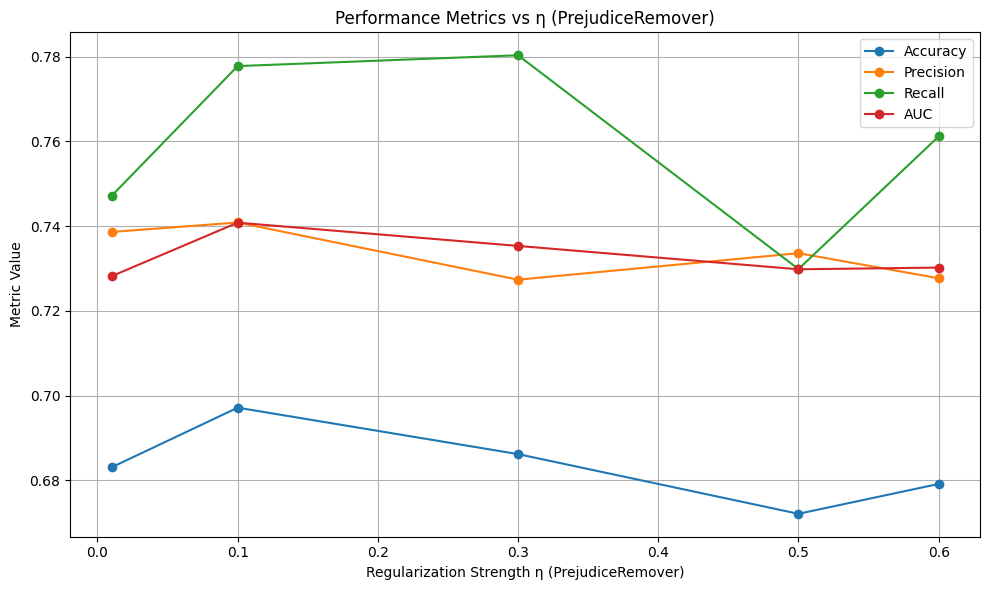

In [121]:
accuracies = [m['accuracy'] for m in inprocessing_performance_metrics]
precisions = [m['precision'] for m in inprocessing_performance_metrics]
recalls = [m['recall'] for m in inprocessing_performance_metrics]
aucs = [m['auc'] for m in inprocessing_performance_metrics]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(reg_weights, accuracies, marker='o', label='Accuracy')
plt.plot(reg_weights, precisions, marker='o', label='Precision')
plt.plot(reg_weights, recalls, marker='o', label='Recall')
plt.plot(reg_weights, aucs, marker='o', label='AUC')
plt.xlabel('Regularization Strength η (PrejudiceRemover)')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs η (PrejudiceRemover)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


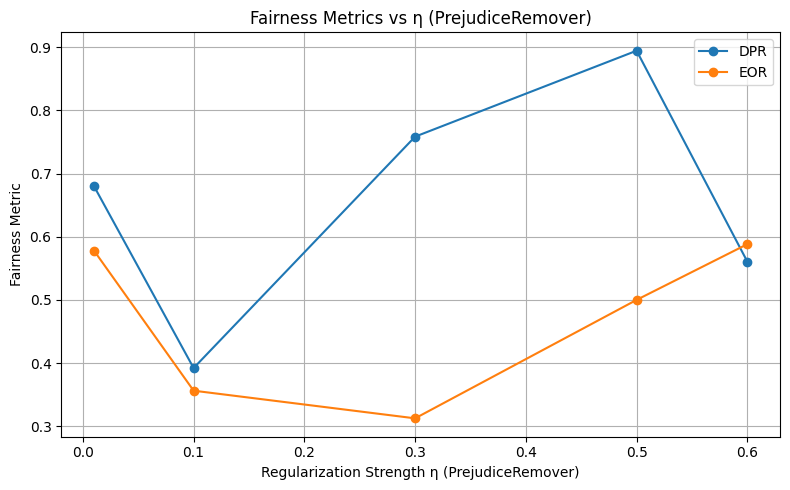

In [122]:
# Estrai fairness metrics
dprs = [m['dpr'] for m in inprocessing_fairness_metrics]
eors = [m['eor'] for m in inprocessing_fairness_metrics]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(reg_weights, dprs, marker='o', label='DPR')
plt.plot(reg_weights, eors, marker='o', label='EOR')
plt.xlabel('Regularization Strength η (PrejudiceRemover)')
plt.ylabel('Fairness Metric')
plt.title('Fairness Metrics vs η (PrejudiceRemover)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Coord-Plot

In [ ]:
X_train_reset = X_train.reset_index(drop=True)
reweighed_reset = reweighed_df.reset_index(drop=True)

# Usa tutti gli indici invece di un campione
all_indices = X_train_reset.index

original_df = X_train_reset.copy()
original_df['group'] = 'Original'

transformed_df = reweighed_reset.copy()
transformed_df['group'] = 'Transformed'

# Applica il ripesamento
transformed_df['job_sector'] = transformed_df['job_sector'] * reweighed_df['weights'].values

# Unisci i due dataframe
combined_df = pd.concat([original_df, transformed_df], ignore_index=True)

# Grafico
plt.figure(figsize=(12, 6))
for group, style, color in zip(['Original', 'Transformed'], ['-', '--'], ['blue', 'darkorange']):
    parallel_coordinates(
        combined_df[combined_df['group'] == group],
        class_column='group',
        color=[color],
        linestyle=style,
        alpha=0.7,
        ax=plt.gca()
    )

plt.xticks(rotation=45)
plt.title("Coordinate Plot: Original vs Transformed")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(["Original", "Transformed"], loc="best")
plt.tight_layout()
plt.show()
